1. Desciptive stats inkl sentiment evt. - Ellen
> Avg. sentiment for hver udgiver, wordclouds, correlation heatmap for engagement metrics, plot timeseries (article count og eller engangement sum over tid). Plus andre gode idéer :).
2. sLDA - Julius
> Først normal LDA, vis topics og lav regression som baseline og så sLDA.
3. NN text - Jens
4. CNN billeder - Cille og Benji

# Project: Engagement prediction of news articles on Facebook

**42578 Advanced Business Analytics**

DTU, 1st of April 2022

_Name and study ID_: 

| Name | Study ID |
| --- | --- |
| Benjamin | s184314|
| Cecilie | s184304|
| Ellen | s184313|
| Jens | s183568 | 
| Julius | s184288 | 

## Description of chosen dataset
This dataset *Internet news data with readers engagement* is downloaded from Kaggle (link: https://www.kaggle.com/szymonjanowski/internet-articles-data-with-users-engagement). The dataset contains basic information about news articles: publisher, author, title and a short description together with engagement signals on Facebook (e.g. number of likes). Besides that, each article is provided with an URL to both the news article and associated photo, so it is possible to scrape extra information.   

The dataset consists of 10.437 rows and 14 columns. The data was collected between 03.09.2019 and 03.10.2019 (DD.MM.YYYY). 


## Research questions

This project will focus on how the engagement of new articles is impacted by the contents of the article such as the title, description and the image. To carry out the analysis several research questions have been created:

* Which attributes contribute most to the engagement?

* What metric best describes the value of engagement based on the given counts of shares, comments and reactions?

* What similarities can be found between the articles with a high engagement count?

* How can a supervised LDA model be used to predict engagement based on topics?

* Can the prediction be improved by using neural networks for modeling both the article content and image?


## Descriptive Stats

To begin with some descriptive statistics is carried out in order to understand and process the data for the following analysis. 

**Loading packages**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


#Benji og Cille Packages
import cv2
import requests
import imageio
from PIL import Image

In [9]:
# Import the following in order to access the .csv document in the folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
#df = pd.read_csv("drive/MyDrive/ABA project/articles_data.csv", index_col=0)
#df.head(5)

# Image processing and analysis

Explanation on the HSV colors can be found in this [link](https://realpython.com/python-opencv-color-spaces/).     
* H = Hue (color)
* S = Saturation (the shades of hue) 
* V = Value (brightness of the color)

<div>
    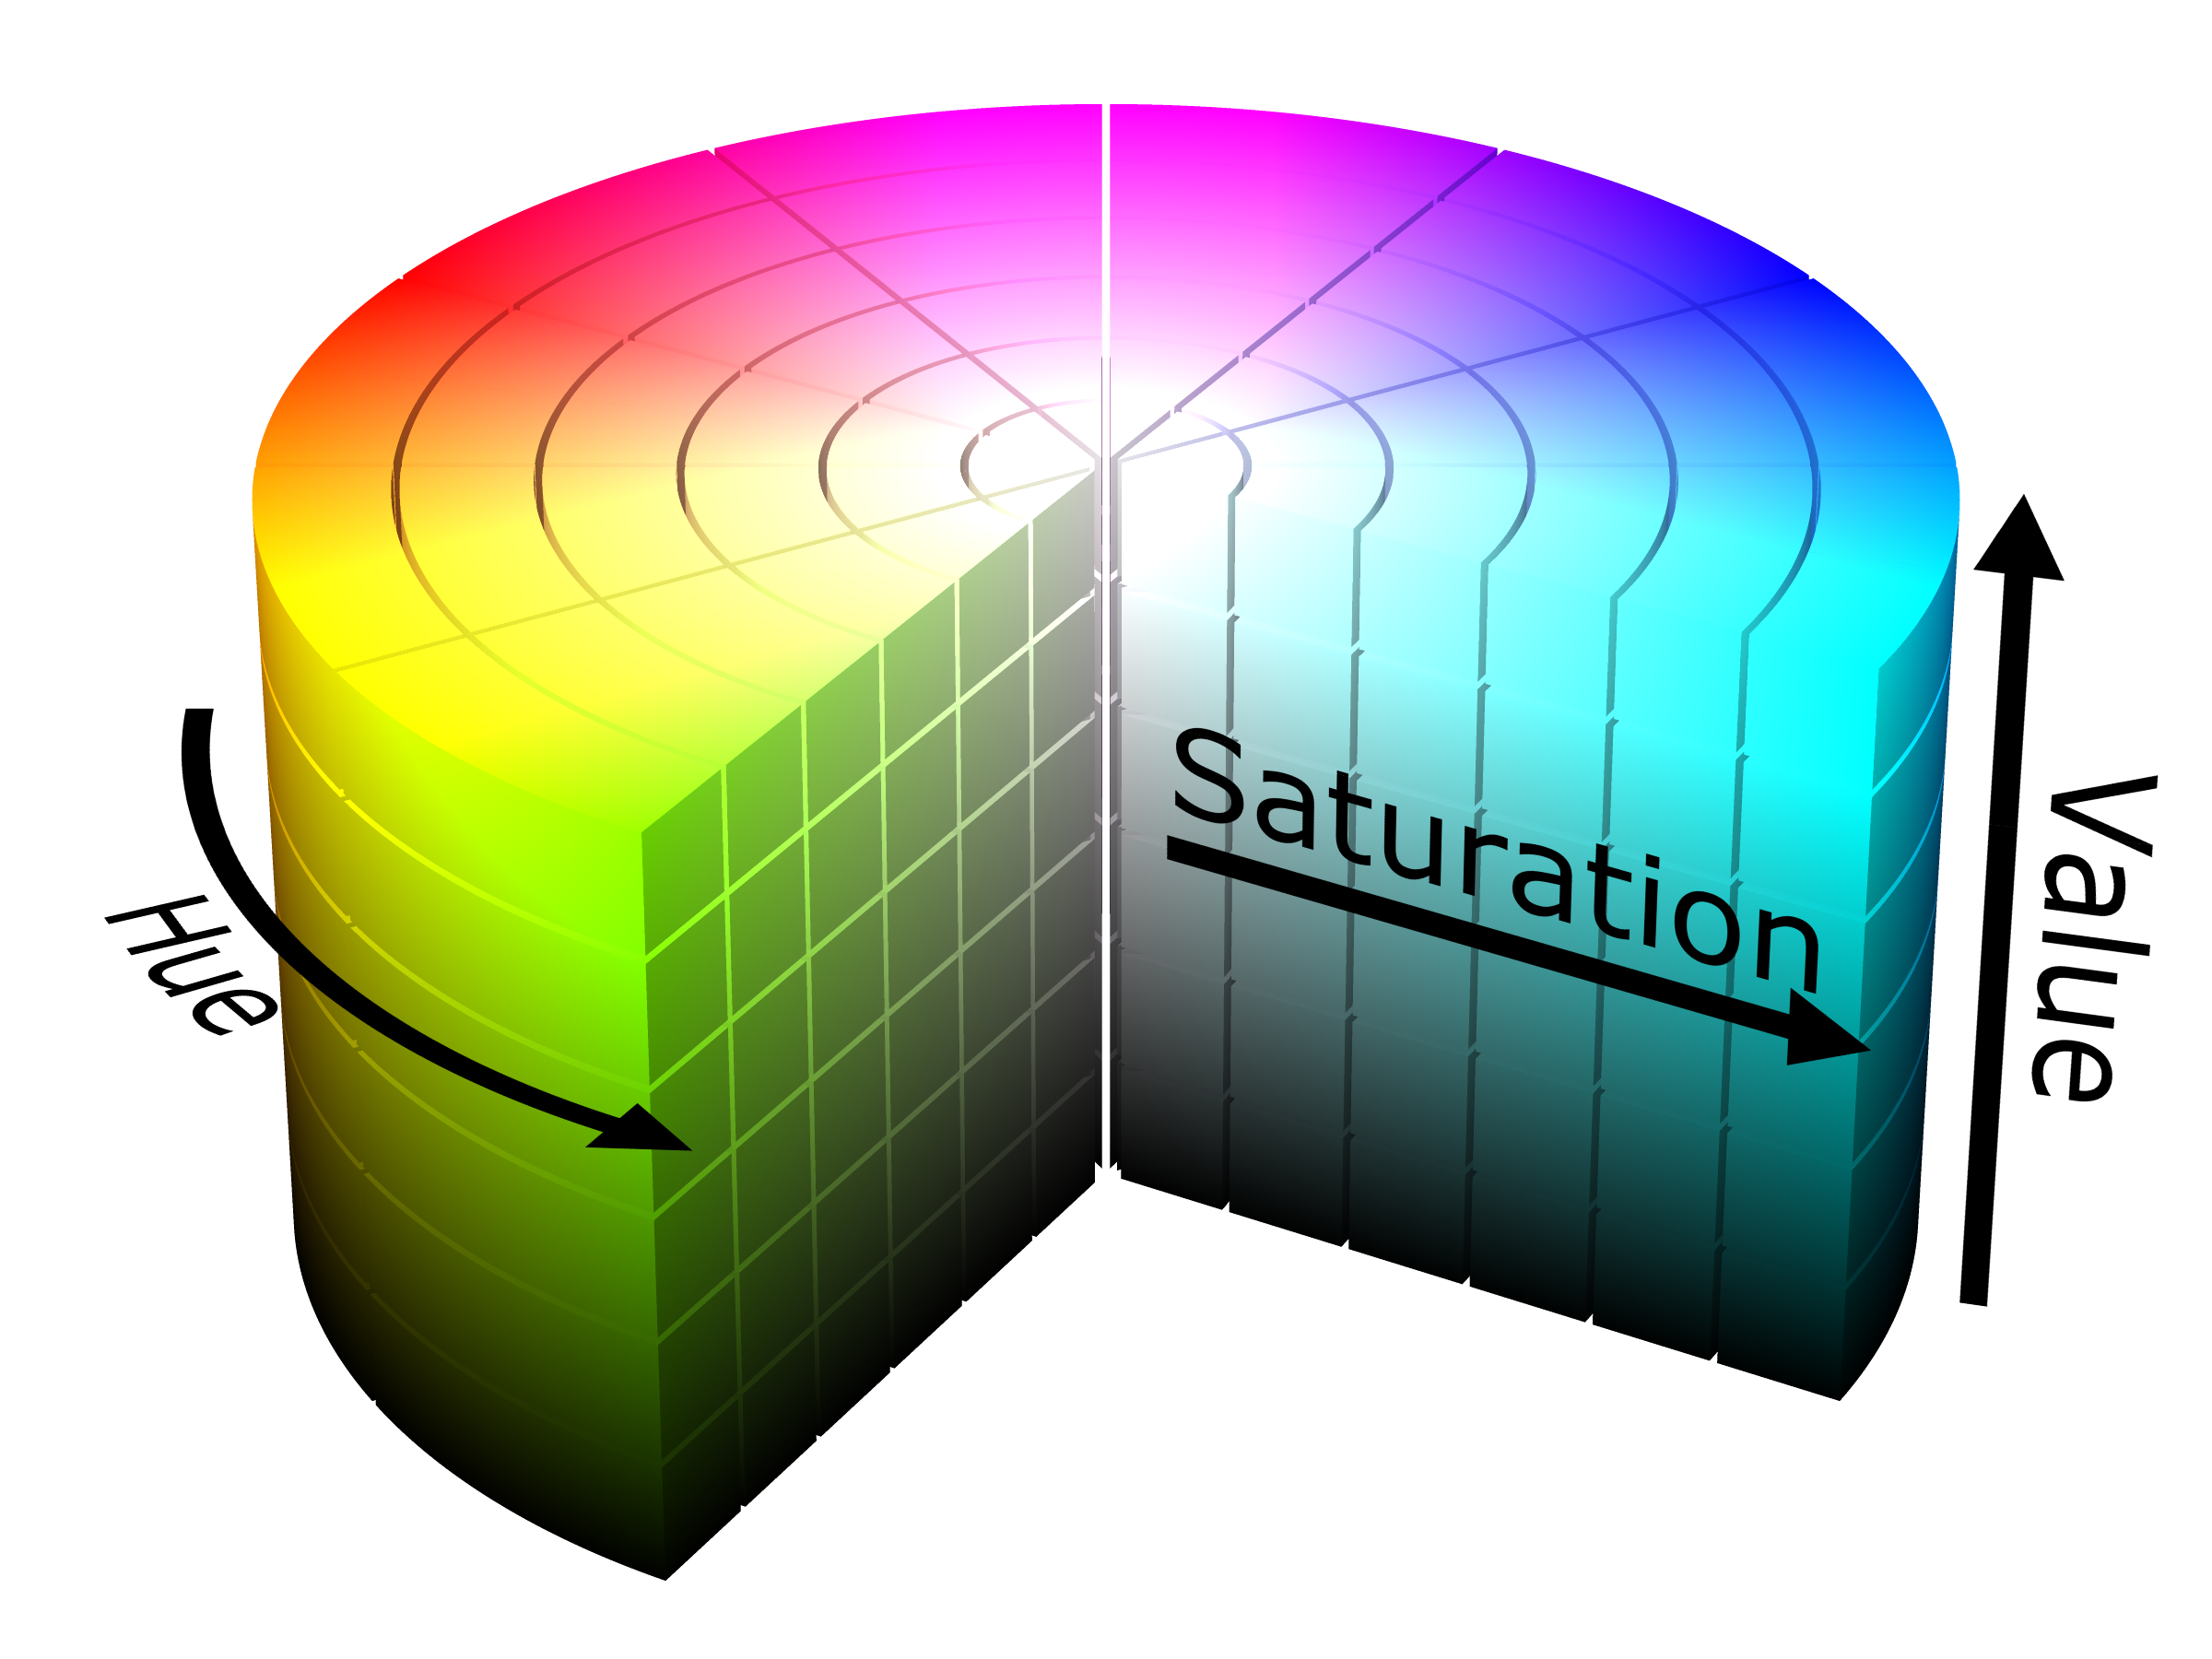
</div>



In [4]:
#pip install opencv-python

In [5]:
#function to process one image
def process_image(url):
    res = requests.get(url)
    im = imageio.imread((res.content))

    #get dims
    width = im.shape[1]
    height = im.shape[0]
    dimensions = im.ndim
    
    #getting the HSV colors
    mean_hsv = cv2.mean(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))    
    hue_mean = mean_hsv[0]
    sat_mean = mean_hsv[1]
    bright_mean = mean_hsv[2]
    
    #return mean values
    return width,height,dimensions, hue_mean,sat_mean,bright_mean

In [39]:
#function to process one image
def read_image(url):
    res = requests.get(url)
    im = imageio.imread((res.content))
    return im

#function that outputs the image
def print_image(url):
    res = requests.get(url)
    im = imageio.imread((res.content))
    return Image.fromarray(im).resize((500, 300), Image.ANTIALIAS)

In [9]:
df[["img_width", "img_height", 'img_dim', 'img_hue', 'img_sat', 'img_val']] = np.nan

In [10]:
df = df.reset_index()

In [ ]:
#WARNING: This code has a very long runtime. The output data has been saved in a new csv. So download this instead.
for i in range(len(df)):
    url = df.iloc[i]["url_to_image"]
    if pd.isna(url) == False:
        #print(url)
        try:
            width,height,dimensions,hue_mean,sat_mean,bright_mean = process_image(url)
            df["img_width"][i],  df["img_height"][i], df["img_dim"][i], df["img_hue"][i], df["img_sat"][i], df["img_val"][i] = width,height,dimensions,hue_mean,sat_mean,bright_mean
        except:
            pass

In [13]:
df.to_csv('new_data.csv')

In [14]:
#df = pd.read_csv("drive/MyDrive/ABA project/new_data.csv", index_col=0)
df = pd.read_csv("new_data.csv", index_col=0)

In [12]:
#df = df.drop(['level_0', 'index'], axis=1)

In [16]:
print("Row with highest Hue:", df['img_hue'].idxmax())
print("Row with highest Saturation:", df['img_sat'].idxmax())
print("Row with highest Brightness:", df['img_val'].idxmax())
print("--------------------------------------------")
print("Row with lowest Hue:", df['img_hue'].idxmin())
print("Row with lowest Saturation:", df['img_sat'].idxmin())
print("Row with lowest Brightness:", df['img_val'].idxmin())

Row with highest Hue: 1261
Row with highest Saturation: 1982
Row with highest Brightness: 641
--------------------------------------------
Row with lowest Hue: 16
Row with lowest Saturation: 16
Row with lowest Brightness: 4275


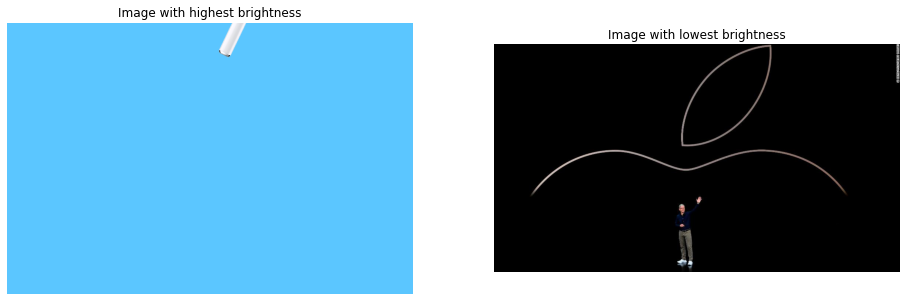

In [98]:
img1 = imageio.imread(df.iloc[df['img_val'].idxmax()].url_to_image)
img2 = imageio.imread(df.iloc[df['img_val'].idxmin()].url_to_image)

f, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Image with highest brightness')
ax[1].set_title('Image with lowest brightness')
plt.show()

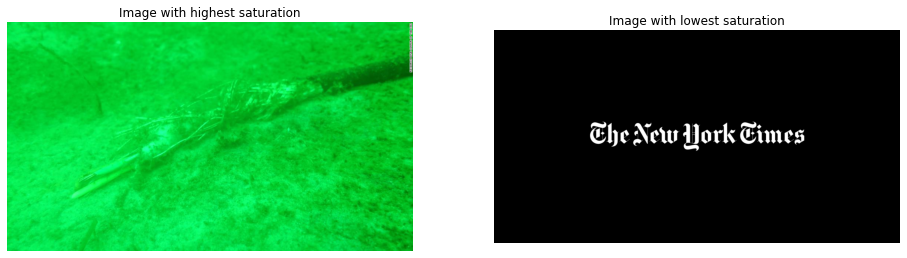

In [100]:
img1 = imageio.imread(df.iloc[df['img_sat'].idxmax()].url_to_image)
img2 = imageio.imread(df.iloc[df['img_sat'].idxmin()].url_to_image)

f, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Image with highest saturation')
ax[1].set_title('Image with lowest saturation')
plt.show()

## Investigating correlations

In [25]:
#df = pd.read_csv("drive/MyDrive/ABA project/new_data.csv", index_col=0)

In [101]:
fig = make_subplots(rows=1, cols=1,shared_xaxes=True)

s_val =df[["engagement_reaction_count", "engagement_comment_count", "engagement_share_count", "img_hue", "img_sat", "img_val"]].corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',xgap=1,ygap=1, colorscale='RdBu'),
    row=1, col=1)

fig.update_layout(height=600, width=900, title_text="Pearson correlation")
fig.show()

Conclusion: We cannot use the HSV to anything.

# CNN - Cille

In [14]:
#df = pd.read_csv("drive/MyDrive/ABA project/new_data.csv", index_col=0)

In [15]:
#df = df.reset_index()

In [102]:
print("Row with highest engagement (reaction count):", df['total_engagement'].idxmax())
print("Row with lowest engagement (reaction count):", df['total_engagement'].idxmin())

Row with highest engagement (reaction count): 8474
Row with lowest engagement (reaction count): 4


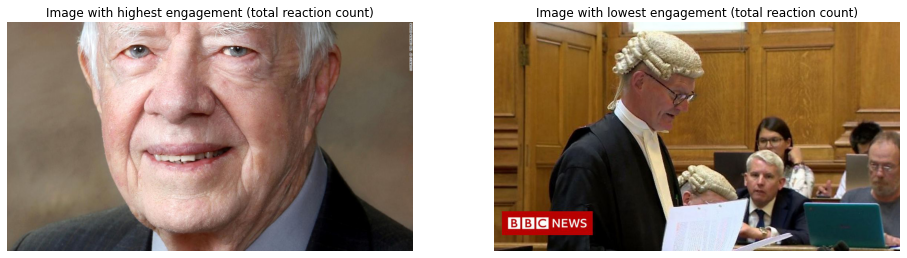

In [105]:
img1 = imageio.imread(df.iloc[df['total_engagement'].idxmax()].url_to_image)
img2 = imageio.imread(df.iloc[df['total_engagement'].idxmin()].url_to_image)

f, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Image with highest engagement (total reaction count)')
ax[1].set_title('Image with lowest engagement (total reaction count)')
plt.show()

In [ ]:
#WARNING: Takes a long time to run!!! Import the array instead!
#The following list loads data from the images. 

im_list = []

for i in range(len(df)):
    url = df.iloc[i]["url_to_image"]
    if pd.isna(url) == False:
        try:
            im = read_image(df.iloc[0].url_to_image)
            im = cv2.resize(im, (32, 32)) #it is important that all images have the same size
            im_list.append(im)
        except:
            im_list.append(0)
            pass
    else:
        im_list.append(0)

In [ ]:
#this codes saves the list generated from the code above.
#np.save('image_list', im_list) # save the file as "outfile_name.npy" 

In [106]:
# We can now load the array
#im_list_new = np.load('drive/MyDrive/ABA project/image_list.npy', allow_pickle=True)
im_list_new = np.load('image_list.npy', allow_pickle=True)

In [107]:
Y = np.array(df.loc[:,"total_engagement"])
Y.shape

(10410,)

In [108]:
X = im_list_new
X.shape

(10410,)

Not all rows have an URL code, thus not all rows have information about the image in the article. In the array X these rows have the value 0. We have to drop these rows as they cannot be used in the model. 

In [109]:
# Index of elements to be deleted
del_ele = [i for i in range(len(X)) if isinstance(X[i], np.ndarray) == False ]

# Delete the elements in both X and Y
X_new = [i for j, i in enumerate(X) if j not in del_ele]
Y_new = [i for j, i in enumerate(Y) if j not in del_ele]

Checking for NaN values in Y. 

In [110]:
sum(np.isnan(Y_new))

117

We will delete these observations

In [111]:
# Index of elements to be deleted
del_ele = [i for i in range(len(Y_new)) if np.isnan(Y_new[i]) == True]

# Delete the elements in both X and Y
X_new = [i for j, i in enumerate(X_new) if j not in del_ele]
Y_new = [i for j, i in enumerate(Y_new) if j not in del_ele]

In [112]:
print(len(Y_new))
print(len(X_new))

9005
9005


Next up is to create classes from the Y data. The data is divided into class 0 (engagement <= 10) and 1 (engagement > 10).

In [113]:
Y_new = np.array(Y_new)

In [114]:
Y_new[Y_new <= 10] = 0
Y_new[Y_new > 10] = 1

In [115]:
(unique, counts) = np.unique(Y_new, return_counts=True)
print(unique)
print(counts)

[0. 1.]
[4103 4902]


In [116]:
sum(Y_new==1)/len(Y_new)

0.544364242087729

In the above it is indicated that the shape of the image is 32x32, which means that each picture has have 1,240 pixels in the data. If it was RGB colors it would have a fourth dimension indicating the three layers/channels in RGB. But now it is gray-scale, thus it only has one channel.   

We also have to flatten the data for each image, because if we then take multiple such images and try and label them as different articles we can analyze the pixel values and look for patterns in them. 

The data right now is in an int8 format, so we need to convert its type to float32, and we also rescale the pixel values in range 0 - 1 inclusive.

I think the data is ready for modelling now..

### CNN


In [117]:
#df = pd.read_csv("drive/MyDrive/ABA project/new_data.csv", index_col=0)

In [119]:
len(Y_new)

9005

In [25]:
Y=np.array(df.total_engagement)

In [26]:
# Index of elements to be deleted
del_ele = [i for i in range(len(Y)) if np.isnan(Y[i]) == True]
len(del_ele)

117

In [27]:
df=df.drop(del_ele, axis=0)

In [28]:
len(df)

10293

In [29]:
im_list_new = np.load('drive/MyDrive/ABA project/image_list.npy', allow_pickle=True)
X=im_list_new

In [30]:
len(X)

10410

In [31]:
len(df)

10293

In [32]:
# Index of elements to be deleted
del_ele = [i for i in range(len(X)) if isinstance(X[i], np.ndarray) == False ]

# Delete the elements in both X and Y
X_new = [i for j, i in enumerate(X) if j not in del_ele]
Y_new = [i for j, i in enumerate(Y) if j not in del_ele]
len(df)

10293

In [33]:
df=df.drop(del_ele, axis=0)


In [34]:
image_df=df[["url_to_image","total_engagement"]]

Y=[]
for i in image_df["total_engagement"]:
  if i>10:
    Y.append(1)
  else:
    Y.append(0)
Y=np.array(Y)

In [35]:
image_df["total_engagement"]=Y
image_df

url_to_image  total_engagement
0      https://s4.reutersmedia.net/resources/r/?m=02&...                 1
1      https://www.irishtimes.com/image-creator/?id=1...                 1
3      https://www.aljazeera.com/mritems/Images/2019/...                 0
4      https://ichef.bbci.co.uk/news/1024/branded_new...                 0
6      https://s2.reutersmedia.net/resources/r/?m=02&...                 1
...                                                  ...               ...
10405  https://s.abcnews.com/images/US/WireAP_eb147c9...                 0
10406  https://s3.reutersmedia.net/resources/r/?m=02&...                 1
10407  https://cdn.cnn.com/cnnnext/dam/assets/1910021...                 1
10408  https://cbsnews1.cbsistatic.com/hub/i/r/2019/1...                 0
10409  https://cbsnews1.cbsistatic.com/hub/i/r/2017/0...                 0

[9649 rows x 2 columns]

In [36]:
sum(Y)/len(Y)

0.5528033993159913

In [37]:
image_df.reset_index(inplace=True)

In [38]:
image_df=image_df.drop("index",axis=1)

In [39]:
image_df=image_df.drop(20,axis=0)
image_df=image_df.reset_index()
image_df.drop("index",axis=1,inplace=True)

In [40]:
import urllib.request
import os

In [ ]:
#import urllib.request

#python 3
#for i in range(len(image_df)):
  #try:
   #fullfilename=os.path.join(r"/content/drive/MyDrive/Images",str(i)+".jpg")
    #url=image_df.loc[i]["url_to_image"]
    #urllib.request.urlretrieve(url, fullfilename)
  #except:
    #print(i)
    #pass

25
34
55
57
62
69
86
122
146
151
158
161
168
172
174
175
182
192
198
206
221
230
248
250
258
262
266
268
274
275
276
298
309
317
331
333
334
341
351
367
381
417
420
423
434
451
455
474
483
528
530
531
533
549
550
561
567
570
577
602
607
611
612
615
616
621
633
635
636
668
682
706
708
710
711
727
740
757
759
761
773
775
776
777
817
818
829
833
834
857
872
880
888
889
894
897
902
912
916
917
940
941
945
949
957
965
971
983
990
993
997
998
1015
1016
1022
1023
1041
1045
1052
1061
1067
1072
1106
1107
1117
1128
1150
1171
1172
1189
1216
1220
1238
1239
1246
1248
1275
1303
1321
1334
1343
1348
1349
1350
1352
1353
1390
1395
1446
1469
1472
1476
1480
1481
1530
1535
1566
1573
1577
1582
1584
1588
1592
1593
1643
1666
1673
1691
1706
1709
1710
1720
1728
1740
1742
1757
1767
1771
1785
1801
1811
1816
1820
1823
1842
1850
1856
1858
1860
1862
1863
1874
1887
1897
1899
1902
1903
1915
1924
1926
1927
1930
1932
1943
1945
1963
1986
1999
2004
2005
2010
2032
2047
2048
2074
2076
2085
2087
2090
2100
2105
2125
2135
2136

In [41]:
x_jpg=[]
for i in range(0,9648):
  x_jpg.append(str(i)+".jpg")

In [42]:
filepath=[]
for i in x_jpg:
  filepath.append("drive/MyDrive/Images/"+i)

In [43]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score

In [44]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [317]:
from PIL import Image

#z=[]
#for i in range(0,9647):
  #try:
   # image = Image.open('drive/MyDrive/Images/'+str(i)+".jpg")
  #except:
   # print(i)
    #z.append(i)
    #pass



In [311]:
#image_df=image_df.drop(z,axis=0)


KeyError: ignored

In [322]:
#image_df.to_csv('drive/MyDrive/ABA project/image_df.csv')

In [46]:
image_df=pd.read_csv("drive/MyDrive/ABA project/image_df.csv")

In [47]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [48]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [58]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='total_engagement',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='total_engagement',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='total_engagement',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 5042 validated image filenames.
Found 1260 validated image filenames.
Found 2701 validated image filenames.


In [56]:
train_df

Unnamed: 0                                       url_to_image  \
8157        8801  https://image.businessinsider.com/5d8537692e22...   
5298        5850  https://www.irishtimes.com/image-creator/?id=1...   
1913        2134  https://cdn.cnn.com/cnnnext/dam/assets/1810151...   
1651        1834  https://s2.reutersmedia.net/resources/r/?m=02&...   
2176        2423  https://www.irishtimes.com/image-creator/?id=1...   
...          ...                                                ...   
2895        3190  https://ichef.bbci.co.uk/onesport/cps/624/cpsp...   
7813        8455  https://image.businessinsider.com/5d9240752e22...   
905         1019  https://cbsnews1.cbsistatic.com/hub/i/r/2019/0...   
5192        5735  https://cbsnews2.cbsistatic.com/hub/i/r/2019/0...   
235          260  https://s2.reutersmedia.net/resources/r/?m=02&...   

      total_engagement                       filepath  
8157                 1  drive/MyDrive/Images/8801.jpg  
5298                 0  drive/MyDrive/Images/5850.jpg  
1913                 1  drive/MyDrive/Images/2134.jpg  
1651                 0  drive/MyDrive/Images/1834.jpg  
2176                 0  drive/MyDrive/Images/2423.jpg  
...                ...                            ...  
2895                 1  drive/MyDrive/Images/3190.jpg  
7813                 0  drive/MyDrive/Images/8455.jpg  
905                  0  drive/MyDrive/Images/1019.jpg  
5192                 0  drive/MyDrive/Images/5735.jpg  
235                  1   drive/MyDrive/Images/260.jpg  

[6302 rows x 4 columns]

In [57]:
test_df

Unnamed: 0                                       url_to_image  \
7051        7693  https://cbsnews1.cbsistatic.com/hub/i/r/2019/1...   
4598        5073  https://cbsnews3.cbsistatic.com/hub/i/r/2019/0...   
8884        9529  https://www.irishtimes.com/image-creator/?id=1...   
5906        6514  https://cbsnews1.cbsistatic.com/hub/i/r/2019/0...   
82            89  https://d.newsweek.com/en/full/1524248/cul-fas...   
...          ...                                                ...   
7549        8191  https://cbsnews3.cbsistatic.com/hub/i/r/2018/0...   
3948        4356  https://ichef.bbci.co.uk/news/1024/branded_new...   
5643        6222  https://cdn.cnn.com/cnnnext/dam/assets/1909091...   
4892        5405  https://cdn.cnn.com/cnnnext/dam/assets/1909131...   
3259        3597  https://s2.reutersmedia.net/resources/r/?m=02&...   

      total_engagement                       filepath  
7051                 0  drive/MyDrive/Images/7693.jpg  
4598                 1  drive/MyDrive/Images/5073.jpg  
8884                 1  drive/MyDrive/Images/9529.jpg  
5906                 0  drive/MyDrive/Images/6514.jpg  
82                   0    drive/MyDrive/Images/89.jpg  
...                ...                            ...  
7549                 0  drive/MyDrive/Images/8191.jpg  
3948                 1  drive/MyDrive/Images/4356.jpg  
5643                 1  drive/MyDrive/Images/6222.jpg  
4892                 1  drive/MyDrive/Images/5405.jpg  
3259                 0  drive/MyDrive/Images/3597.jpg  

[2701 rows x 4 columns]

In [60]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
158/158 [==============================] - 125s 777ms/step - loss: 0.6749 - accuracy: 0.5837 - val_loss: 0.6567 - val_accuracy: 0.6183
Epoch 2/100
158/158 [==============================] - 114s 721ms/step - loss: 0.6651 - accuracy: 0.6017 - val_loss: 0.6496 - val_accuracy: 0.6413
Epoch 3/100
158/158 [==============================] - 114s 722ms/step - loss: 0.6604 - accuracy: 0.6190 - val_loss: 0.6431 - val_accuracy: 0.6468
Epoch 4/100
158/158 [==============================] - 116s 734ms/step - loss: 0.6561 - accuracy: 0.6196 - val_loss: 0.6418 - val_accuracy: 0.6444
Epoch 5/100
158/158 [==============================] - 125s 790ms/step - loss: 0.6511 - accuracy: 0.6180 - val_loss: 0.6459 - val_accuracy: 0.6476
Epoch 6/100
158/158 [==============================] - 118s 746ms/step - loss: 0.6487 - accuracy: 0.6236 - val_loss: 0.6402 - val_accuracy: 0.6468
Epoch 7/100
158/158 [==============================] - 117s 742ms/step - loss: 0.6465 - accuracy: 0.6261 - val_loss: 0

In [61]:
pd.read_csv("drive/MyDrive/ABA project/image_df.csv",index_col=0)

url_to_image  total_engagement  \
0     https://s4.reutersmedia.net/resources/r/?m=02&...                 1   
1     https://www.irishtimes.com/image-creator/?id=1...                 1   
2     https://www.aljazeera.com/mritems/Images/2019/...                 0   
3     https://ichef.bbci.co.uk/news/1024/branded_new...                 0   
4     https://s2.reutersmedia.net/resources/r/?m=02&...                 1   
...                                                 ...               ...   
9643  https://s.abcnews.com/images/US/WireAP_eb147c9...                 0   
9644  https://s3.reutersmedia.net/resources/r/?m=02&...                 1   
9645  https://cdn.cnn.com/cnnnext/dam/assets/1910021...                 1   
9646  https://cbsnews1.cbsistatic.com/hub/i/r/2019/1...                 0   
9647  https://cbsnews1.cbsistatic.com/hub/i/r/2017/0...                 0   

                           filepath  
0        drive/MyDrive/Images/0.jpg  
1        drive/MyDrive/Images/1.jpg  
2        drive/MyDrive/Images/2.jpg  
3        drive/MyDrive/Images/3.jpg  
4        drive/MyDrive/Images/4.jpg  
...                             ...  
9643  drive/MyDrive/Images/9643.jpg  
9644  drive/MyDrive/Images/9644.jpg  
9645  drive/MyDrive/Images/9645.jpg  
9646  drive/MyDrive/Images/9646.jpg  
9647  drive/MyDrive/Images/9647.jpg  

[9003 rows x 3 columns]

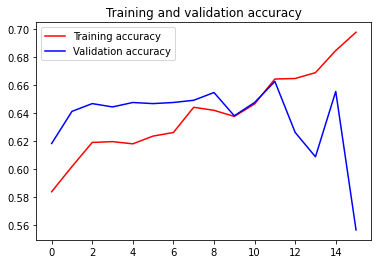

<Figure size 432x288 with 0 Axes>

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
fig1 = plt.gcf()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)


plt.figure()
plt.show()


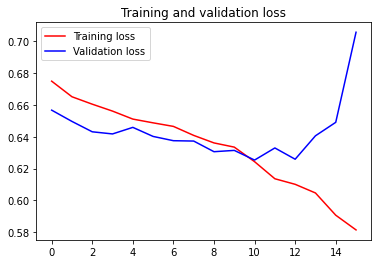

<Figure size 432x288 with 0 Axes>

In [125]:
epochs = range(len(acc))
fig1 = plt.gcf()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)


plt.figure()
plt.show()

In [126]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [127]:
predicted_ages = np.squeeze(model.predict(test_images))
true_ages = test_images.labels

In [114]:
test_df

Unnamed: 0                                       url_to_image  \
7051        7693  https://cbsnews1.cbsistatic.com/hub/i/r/2019/1...   
4598        5073  https://cbsnews3.cbsistatic.com/hub/i/r/2019/0...   
8884        9529  https://www.irishtimes.com/image-creator/?id=1...   
5906        6514  https://cbsnews1.cbsistatic.com/hub/i/r/2019/0...   
82            89  https://d.newsweek.com/en/full/1524248/cul-fas...   
...          ...                                                ...   
7549        8191  https://cbsnews3.cbsistatic.com/hub/i/r/2018/0...   
3948        4356  https://ichef.bbci.co.uk/news/1024/branded_new...   
5643        6222  https://cdn.cnn.com/cnnnext/dam/assets/1909091...   
4892        5405  https://cdn.cnn.com/cnnnext/dam/assets/1909131...   
3259        3597  https://s2.reutersmedia.net/resources/r/?m=02&...   

      total_engagement                       filepath  
7051                 0  drive/MyDrive/Images/7693.jpg  
4598                 1  drive/MyDrive/Images/5073.jpg  
8884                 1  drive/MyDrive/Images/9529.jpg  
5906                 0  drive/MyDrive/Images/6514.jpg  
82                   0    drive/MyDrive/Images/89.jpg  
...                ...                            ...  
7549                 0  drive/MyDrive/Images/8191.jpg  
3948                 1  drive/MyDrive/Images/4356.jpg  
5643                 1  drive/MyDrive/Images/6222.jpg  
4892                 1  drive/MyDrive/Images/5405.jpg  
3259                 0  drive/MyDrive/Images/3597.jpg  

[2701 rows x 4 columns]

In [105]:
model.save("drive/MyDrive/ABA project/model_CNN.pb")

INFO:tensorflow:Assets written to: drive/MyDrive/ABA project/model_CNN.pb/assets


In [10]:
from tensorflow import keras

In [11]:
model = keras.models.load_model('drive/MyDrive/ABA project')

In [111]:
y_pred = np.squeeze(model.predict(test_images,verbose=1))
y_true = test_images.labels

test_images.filenames



33/85 [==========>...................] - ETA: 29s

UnknownError: ignored

In [107]:
test_images.filenames[247]

'drive/MyDrive/Images/7037.jpg'

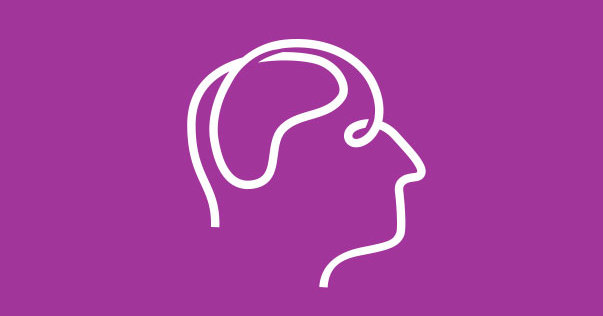

In [110]:
Image.open(test_images.filenames[247])

In [90]:
'drive/MyDrive/Images/3518.jpg'

2701

In [ ]:
import cv2

img = Image.open(os.path.join(sign_path, sign)) # open the image file
          img.verify() # verify that it is, in fact an image
        except (IOError, SyntaxError) as e:
          print('Bad file:', sign) # print out the names of corrupt files

bad_file_list=[]
bad_count=0
try:
    img.cv2.imread(os.path.join(sign_path, sign)
    shape=img.shape # this will throw an error if the img is not read correctly
except:
    bad_file_list.append(os.path.join(sign_path, sign))
    bad_count +=1

In [51]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [52]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
5.652937552000026
GPU (s):
0.08563245599998481
GPU speedup over CPU: 66x
